In [1]:
from keras.models import Model
from keras.layers import Input, Dense, LSTM, multiply, concatenate, Activation, Masking, Reshape,RepeatVector,TimeDistributed
from keras.layers import Conv1D, BatchNormalization, GlobalAveragePooling1D, Permute, Dropout

import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 不加这几句，则CONV 报错
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Using TensorFlow backend.


In [2]:
data = pd.read_csv("./data/data_1009.csv", header=0,infer_datetime_format=True, engine='python')
data['Unnamed: 0']=pd.to_datetime(data['Unnamed: 0'])
data.set_index("Unnamed: 0",inplace=True)

In [3]:
'''
归一化
'''
from sklearn.preprocessing import MinMaxScaler
scaler1 = MinMaxScaler(feature_range=(0, 1))
scaler2 = MinMaxScaler(feature_range=(0, 1))
scaler3 = MinMaxScaler(feature_range=(0, 1))
scaler4 = MinMaxScaler(feature_range=(0, 1))
scaler5 = MinMaxScaler(feature_range=(0, 1))
scaler6 = MinMaxScaler(feature_range=(0, 1))
scaler7 = MinMaxScaler(feature_range=(0, 1))
scaler8 = MinMaxScaler(feature_range=(0, 1))
data_minmax = data.copy()
data_minmax['pm2.5']=scaler1.fit_transform(data_minmax['pm2.5'].values.reshape(-1,1))
data_minmax['DEWP']=scaler2.fit_transform(data_minmax['DEWP'].values.reshape(-1,1))
data_minmax['TEMP']=scaler3.fit_transform(data_minmax['TEMP'].values.reshape(-1,1))
data_minmax['PRES']=scaler4.fit_transform(data_minmax['PRES'].values.reshape(-1,1))
data_minmax['cbwd_NE']=scaler5.fit_transform(data_minmax['cbwd_NE'].values.reshape(-1,1))
data_minmax['cbwd_NW']=scaler6.fit_transform(data_minmax['cbwd_NW'].values.reshape(-1,1))
data_minmax['cbwd_SE']=scaler7.fit_transform(data_minmax['cbwd_SE'].values.reshape(-1,1))
data_minmax['cbwd_cv']=scaler7.fit_transform(data_minmax['cbwd_cv'].values.reshape(-1,1))

In [4]:
'''
取一年的时间，10个月做训练和验证，2个月做测试
'''
cast1 = 35064
cast2 = -1464
data_train = data_minmax[cast1:cast2]
data_test = data_minmax[cast2:] 
data_train.shape,data_test.shape

((7296, 8), (1464, 8))

In [5]:
data_train = np.array(data_train)
data_test = np.array(data_test)
data_train.shape,data_test.shape

((7296, 8), (1464, 8))

In [6]:
from utils.data_split import split_sequence_parallel

In [7]:
sw_width = 21
pred_length = 12
verbose_set = 2
X, y, features = split_sequence_parallel(data_train,sw_width,pred_length)
test_x,test_y,test_features = split_sequence_parallel(data_test,sw_width,pred_length)

In [8]:
test_x,test_y,test_features = split_sequence_parallel(data_test,sw_width,pred_length)
test_x.shape,test_y.shape

((1432, 21, 8), (1432, 12))

In [9]:
def ED_LSTM_model():
#     ip = Input(shape=(MAX_NB_VARIABLES, MAX_TIMESTEPS))
    ip = Input(shape=(sw_width,features))

    x = LSTM(128,activation="relu")(ip)
#     x = Dropout(0.2)(x)
    x = RepeatVector(pred_length)(x)
    x = LSTM(64,activation="relu",return_sequences=True)(x)
#     x = Dropout(0.2)(x)
    
    
    out = TimeDistributed(Dense(1))(x)

    model = Model(ip, out)
    model.summary()


    return model

In [10]:
model = ED_LSTM_model()
model

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 21, 8)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               70144     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 12, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 12, 64)            49408     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 12, 1)             65        
Total params: 119,617
Trainable params: 119,617
Non-trainable params: 0
_________________________________________________________________


In [11]:
y = y.reshape(y.shape[0],y.shape[1],1)

In [14]:
import time
from keras import backend as K
from keras.callbacks import ModelCheckpoint,LearningRateScheduler,ReduceLROnPlateau
# from utils.lr_process import lr_schedule
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true))) 

# lr_scheduler = LearningRateScheduler(lr_schedule)
# lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
#                                cooldown=0,
#                                patience=5,
#                                min_lr=0.5e-6)

filepath = "D:\桌面\空气质量预测综合\北京PM2.5数据集\多步预测\\12hourweights\ED_LSTM_model_weights_best.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min', period=1)
callbacks_list = [checkpoint]

In [15]:
starttime=time.time()
model.compile(loss=root_mean_squared_error, optimizer='adam')
history1 = model.fit(X,y,validation_split=0.25,epochs=100, batch_size=32,callbacks=callbacks_list, verbose=2)
endtime=time.time()
dtime=endtime-starttime
print("程序运行时间为：%.8s s" % dtime)  #时间显示到微秒

Train on 5448 samples, validate on 1816 samples
Epoch 1/100
 - 6s - loss: 0.0595 - val_loss: 0.0466

Epoch 00001: val_loss improved from inf to 0.04660, saving model to D:\桌面\空气质量预测综合\北京PM2.5数据集\多步预测\12hourweights\ED_LSTM_model_weights_best.hdf5
Epoch 2/100
 - 5s - loss: 0.0571 - val_loss: 0.0482

Epoch 00002: val_loss did not improve from 0.04660
Epoch 3/100
 - 5s - loss: 0.0547 - val_loss: 0.0442

Epoch 00003: val_loss improved from 0.04660 to 0.04419, saving model to D:\桌面\空气质量预测综合\北京PM2.5数据集\多步预测\12hourweights\ED_LSTM_model_weights_best.hdf5
Epoch 4/100
 - 5s - loss: 0.0532 - val_loss: 0.0421

Epoch 00004: val_loss improved from 0.04419 to 0.04206, saving model to D:\桌面\空气质量预测综合\北京PM2.5数据集\多步预测\12hourweights\ED_LSTM_model_weights_best.hdf5
Epoch 5/100
 - 5s - loss: 0.0511 - val_loss: 0.0503

Epoch 00005: val_loss did not improve from 0.04206
Epoch 6/100
 - 5s - loss: 0.0519 - val_loss: 0.0450

Epoch 00006: val_loss did not improve from 0.04206
Epoch 7/100
 - 5s - loss: 0.0511 - val

 - 5s - loss: 0.0201 - val_loss: 0.0596

Epoch 00076: val_loss did not improve from 0.04206
Epoch 77/100
 - 5s - loss: 0.0194 - val_loss: 0.0596

Epoch 00077: val_loss did not improve from 0.04206
Epoch 78/100
 - 5s - loss: 0.0195 - val_loss: 0.0612

Epoch 00078: val_loss did not improve from 0.04206
Epoch 79/100
 - 5s - loss: 0.0194 - val_loss: 0.0615

Epoch 00079: val_loss did not improve from 0.04206
Epoch 80/100
 - 5s - loss: 0.0199 - val_loss: 0.0620

Epoch 00080: val_loss did not improve from 0.04206
Epoch 81/100
 - 5s - loss: 0.0205 - val_loss: 0.0608

Epoch 00081: val_loss did not improve from 0.04206
Epoch 82/100
 - 5s - loss: 0.0193 - val_loss: 0.0591

Epoch 00082: val_loss did not improve from 0.04206
Epoch 83/100
 - 5s - loss: 0.0189 - val_loss: 0.0603

Epoch 00083: val_loss did not improve from 0.04206
Epoch 84/100
 - 5s - loss: 0.0187 - val_loss: 0.0604

Epoch 00084: val_loss did not improve from 0.04206
Epoch 85/100
 - 5s - loss: 0.0189 - val_loss: 0.0625

Epoch 00085: v

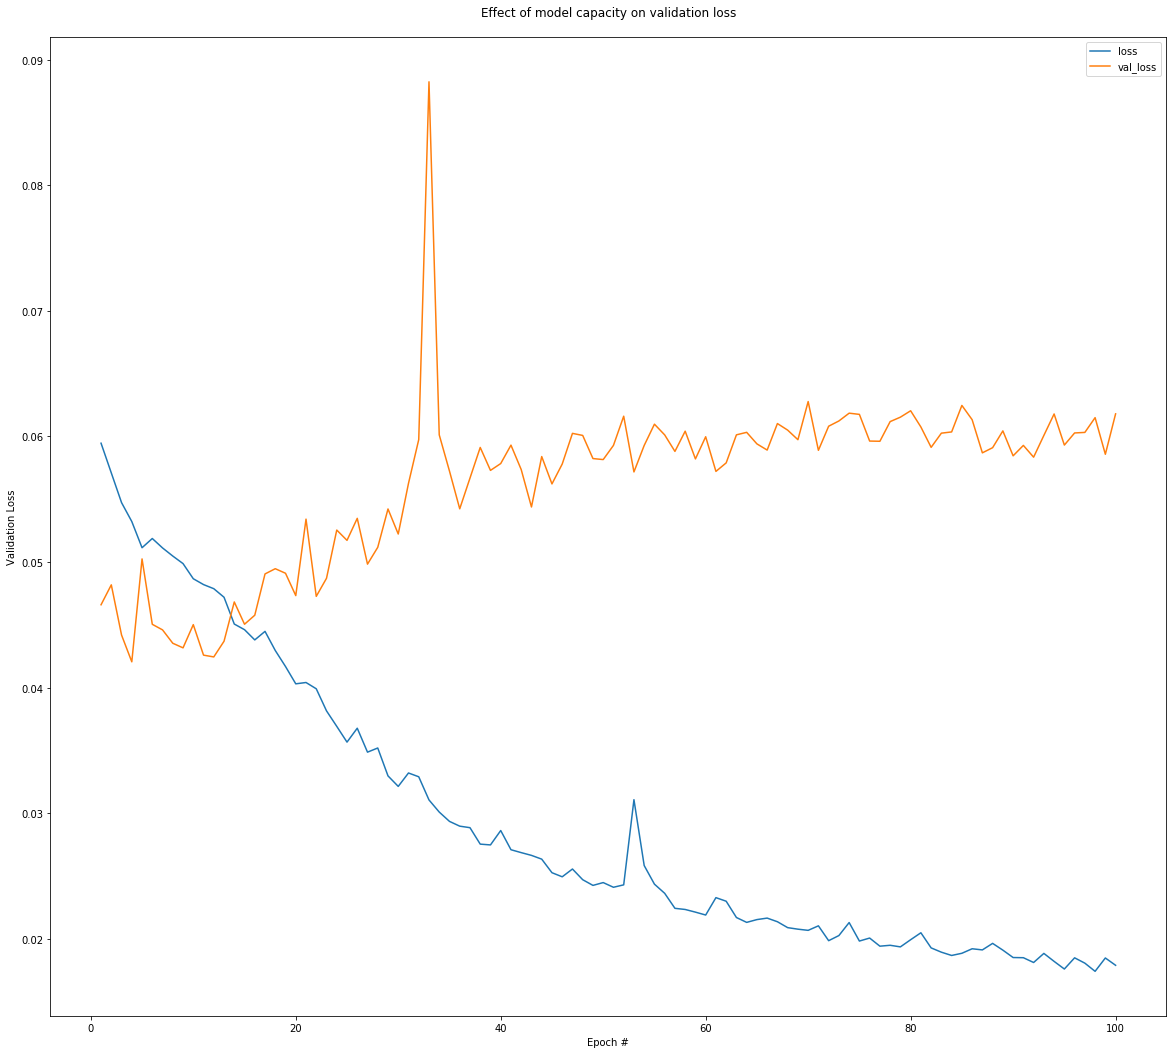

In [16]:
loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs = np.arange(100) + 1
plt.figure(figsize=(20,18))
plt.plot(epochs, loss, label='loss')
plt.plot(epochs, val_loss, label='val_loss')
plt.title("Effect of model capacity on validation loss\n")
plt.xlabel('Epoch #')
plt.ylabel('Validation Loss')
plt.legend()
plt.show()

In [17]:
model.load_weights(filepath)

In [18]:
test_y = test_y.reshape(test_y.shape[0],test_y.shape[1],1)

In [19]:
predict=model.predict(test_x)
predict=scaler1.inverse_transform(predict.reshape(predict.shape[0],predict.shape[1]))

In [20]:
tf.sqrt(tf.losses.mean_squared_error(predict,scaler1.inverse_transform(test_y.reshape(test_y.shape[0],test_y.shape[1])))).numpy().mean()

52.18843284468231

In [21]:
for i in range(7):
    loss1 = tf.sqrt(tf.losses.mean_squared_error(predict[:,i],scaler1.inverse_transform(test_y.reshape(test_y.shape[0],test_y.shape[1]))[:,i])).numpy()
    print(i,":",loss1)

0 : 35.95100004058251
1 : 44.676159833410665
2 : 53.21648515269708
3 : 59.99438360476742
4 : 65.76827029523301
5 : 70.68903847464905
6 : 75.11997126943521


In [22]:
tf.sqrt(tf.losses.mae(predict,scaler1.inverse_transform(test_y.reshape(test_y.shape[0],test_y.shape[1])))).numpy().mean()

6.109468332445529

In [23]:
for i in range(7):
    loss1 = tf.sqrt(tf.losses.mae(predict[:,i],scaler1.inverse_transform(test_y.reshape(test_y.shape[0],test_y.shape[1]))[:,i])).numpy()
    print(i,":",loss1)

0 : 4.80134724899604
1 : 5.271923440596317
2 : 5.725836593372887
3 : 6.098614743166446
4 : 6.422689391284806
5 : 6.711279578422482
6 : 6.98834594844612


In [25]:
print(tf.sqrt(tf.losses.mean_squared_error(predict[:,:6],scaler1.inverse_transform(test_y.reshape(test_y.shape[0],test_y.shape[1]))[:,:6])).numpy().mean())
print(tf.losses.mae(predict[:,:6],scaler1.inverse_transform(test_y.reshape(test_y.shape[0],test_y.shape[1]))[:,:6]).numpy().mean())
print(tf.sqrt(tf.losses.mean_squared_error(predict[:,6:],scaler1.inverse_transform(test_y.reshape(test_y.shape[0],test_y.shape[1]))[:,6:])).numpy().mean())
print(tf.losses.mae(predict[:,6:],scaler1.inverse_transform(test_y.reshape(test_y.shape[0],test_y.shape[1]))[:,6:]).numpy().mean())

38.519987081838906
34.519438540866496
60.16019887069203
56.8523474070391
